In [6]:
import damask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
resultfile_path = 'reference_output/tensionX_material_fullfield_10grains_Al_10grains_voronoi_5x5x5/simulation_output.hdf5'

In [8]:
result = damask.Result(resultfile_path)
if isinstance(result.view(increments=0).get('F'), dict):
    raise RuntimeError('The selected resultfile comes from a multiphase simulation, please use post_processing_fullfield_multiphase.ipynb for this file instead')

try:
    result.add_stress_Cauchy()
except ValueError:
    pass
try:
    result.add_equivalent_Mises('sigma')
except ValueError:
    pass
try:
    result.add_stress_second_Piola_Kirchhoff()
except ValueError:
    pass

try:
    result.add_strain()
except ValueError:
    pass

postprossecing_dir = Path(resultfile_path).stem
vti_path = list(Path(resultfile_path).parent.glob("*.vti"))[0]
grid = damask.GeomGrid.load(vti_path)
grid

cells:  5 × 5 × 5
size:   5e-05 × 5e-05 × 5e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 10

# Example: Stress-strain curve for tensionX

/tmp/ipykernel_4014119/2294557117.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cumulative_data = pd.concat((cumulative_data, grain_data), ignore_index=True)


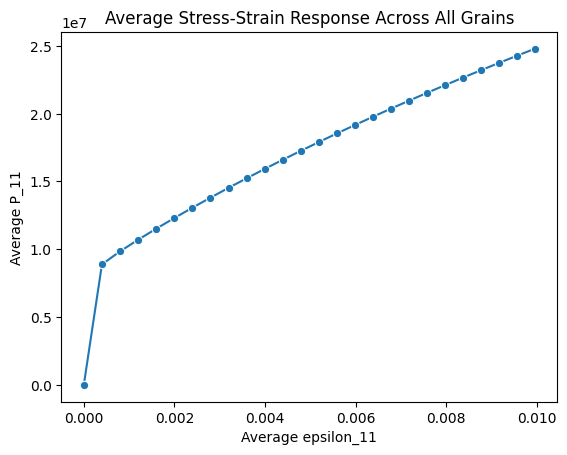

In [10]:
def plot_average_stress_strain_fullfield(grid, result):
    cumulative_data = pd.DataFrame(columns=['F_11', 'P_11'])  # Store all F_11 and P_11 values across grains

    for inc in result.get(['epsilon_V^0.0(F)', 'P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']
        for g in range(np.max(grid.material.flatten(order='F')) + 1):
            points = grid.material.flatten(order='F') == g
            P_11 = P[points, 0, 0].flatten()
            epsilon_11 = np.broadcast_to(np.average(epsilon[:, 0, 0]), P_11.shape)
            grain_data = pd.DataFrame({'epsilon_11': epsilon_11, 'P_11': P_11})
            cumulative_data = pd.concat((cumulative_data, grain_data), ignore_index=True)
    average_data = cumulative_data.groupby('epsilon_11', as_index=False).mean()

    sns.lineplot(x='epsilon_11', y='P_11', data=average_data, marker='o')
    plt.xlabel("Average epsilon_11")
    plt.ylabel("Average P_11")
    plt.title("Average Stress-Strain Response Across All Grains")
    plt.show()

plot_average_stress_strain_fullfield(grid, result)

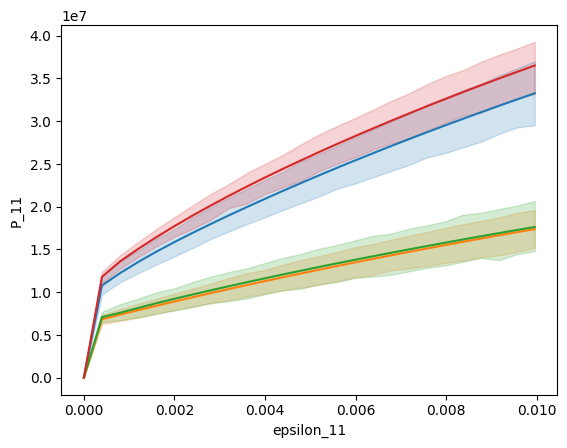

In [13]:
def plot_stress_strain_per_grain_fullfield(grains, grid, result):
    data = {g:pd.DataFrame() for g in grains}
    for inc in result.get(['epsilon_V^0.0(F)','P']).values():
        P = inc['P']
        epsilon = inc['epsilon_V^0.0(F)']
        for g in grains:
            points = grid.material.flatten(order='F')==g
            P_11 = P[points,0,0].flatten()
            epsilon_11 = np.broadcast_to(np.average(epsilon[:,0,0]),P_11.shape)
            x = pd.DataFrame({'epsilon_11':epsilon_11,'P_11':P_11})
            data[g] = pd.concat((data[g],x),ignore_index=True)
    for g in grains:
      plot = sns.lineplot(y='P_11',x='epsilon_11',data=data[g])
    fig = plot.get_figure()

plot_stress_strain_per_grain_fullfield([0, 1, 2, 3], grid, result)


# Example: Stress-Strain Density plot for each grain 

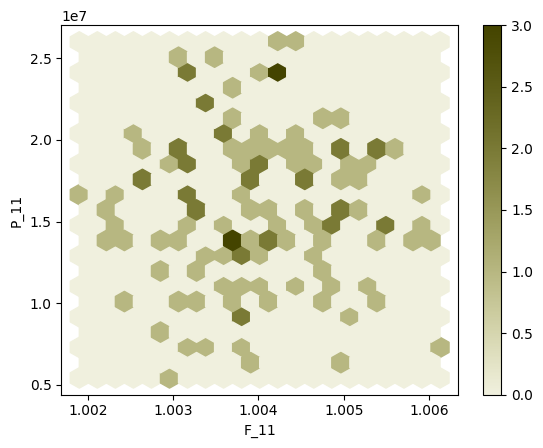

In [12]:
F_data = result.get('F')['increment_40']
P_data = result.get('P')['increment_40']

# slice the arrays to get F_11 and P_11
df = pd.DataFrame({
    'F_11': F_data[:, 0, 0],  # F(1,1)
    'P_11': P_data[:, 0, 0]   # P(1,1)
})

# Plotting density with hexbin
_ = df.plot.hexbin(x='F_11', y='P_11', gridsize=20, cmap=damask.Colormap.from_predefined('strain'))